In [22]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

## Load Data

In [23]:
import pandas as pd

In [24]:
snli_train = pd.read_csv('snli_train.tsv', sep='\t', header=0)
snli_val = pd.read_csv('snli_val.tsv', sep='\t', header=0)

In [25]:
print(snli_train.loc[0]['sentence1'])
print(len(snli_train))
print(len(snli_val))

A young girl in a pink shirt sitting on a dock viewing a body of water .
100000
1000


In [26]:
print(snli_train.loc[0])
print(snli_train.loc[1])
print(snli_train.loc[2])
print(snli_train.loc[3])
print(snli_train.loc[4])

sentence1    A young girl in a pink shirt sitting on a dock...
sentence2    A young girl watching the sunset over the water .
label                                                  neutral
Name: 0, dtype: object
sentence1    A woman is smiling while the man next to her i...
sentence2                  Two people are next to each other .
label                                               entailment
Name: 1, dtype: object
sentence1    Across the river , you can see a large building .
sentence2    The large building is full of apartments and t...
label                                                  neutral
Name: 2, dtype: object
sentence1    a man in white shorts and a black shirt is par...
sentence2              A man is riding a jetski on the ocean .
label                                            contradiction
Name: 3, dtype: object
sentence1    Four black dogs run together on bright green g...
sentence2    Four dogs are preparing to be launched into sp...
label                     

In [27]:
MAX_SEN_LENGTH = 0
for i in range(len(snli_train)):
    MAX_SEN_LENGTH = max(MAX_SEN_LENGTH, len(snli_train.loc[i]['sentence1'].split()))
    MAX_SEN_LENGTH = max(MAX_SEN_LENGTH, len(snli_train.loc[i]['sentence2'].split()))
print(MAX_SEN_LENGTH)

82


## Fast Text Vec

In [28]:
import numpy as np

words_to_load = 50000

with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i == 0: continue
        if i >= words_to_load+1: 
            break
        s = line.split()
        if i == 1:
            print(s[0], s[1:])
        loaded_embeddings_ft[i+1,:] = np.asarray(s[1:])
        words_ft[s[0]] = i+1
        idx2words_ft[i+1] = s[0]
        ordered_words_ft.append(s[0])
        
idx2words_ft[0] = '<PAD>'
idx2words_ft[1] = '<UNK>'
words_ft['<PAD>'] = 0
words_ft['<UNK>'] = 1
#loaded_embeddings_ft[0] = np.ones(300)
loaded_embeddings_ft[0] = np.random.rand(len(loaded_embeddings_ft[0]))
loaded_embeddings_ft[1] = np.random.rand(len(loaded_embeddings_ft[1]))


, ['0.1073', '0.0089', '0.0006', '0.0055', '-0.0646', '-0.0600', '0.0450', '-0.0133', '-0.0357', '0.0430', '-0.0356', '-0.0032', '0.0073', '-0.0001', '0.0258', '-0.0166', '0.0075', '0.0686', '0.0392', '0.0753', '0.0115', '-0.0087', '0.0421', '0.0265', '-0.0601', '0.2420', '0.0199', '-0.0739', '-0.0031', '-0.0263', '-0.0062', '0.0168', '-0.0357', '-0.0249', '0.0190', '-0.0184', '-0.0537', '0.1420', '0.0600', '0.0226', '-0.0038', '-0.0675', '-0.0036', '-0.0080', '0.0570', '0.0208', '0.0223', '-0.0256', '-0.0153', '0.0022', '-0.0482', '0.0131', '-0.6016', '-0.0088', '0.0106', '0.0229', '0.0336', '0.0071', '0.0887', '0.0237', '-0.0290', '-0.0405', '-0.0125', '0.0147', '0.0475', '0.0647', '0.0474', '0.0199', '0.0408', '0.0322', '0.0036', '0.0350', '-0.0723', '-0.0305', '0.0184', '-0.0026', '0.0240', '-0.0160', '-0.0308', '0.0434', '0.0147', '-0.0457', '-0.0267', '-0.1703', '-0.0099', '0.0417', '0.0235', '-0.0260', '-0.1519', '-0.0116', '-0.0306', '-0.0413', '0.0330', '0.0723', '0.0365', '-0

In [29]:
print(loaded_embeddings_ft[words_ft["<UNK>"]])

[ 0.69120168  0.11884392  0.58081382  0.37013563  0.59587431  0.29941795
  0.50118764  0.3482824   0.54951665  0.92179612  0.53184491  0.58050039
  0.6552946   0.27344128  0.659706    0.56383939  0.79625265  0.08156667
  0.74656231  0.15269574  0.59391223  0.42883426  0.99869903  0.64588227
  0.85709441  0.41877265  0.10935624  0.88897563  0.89546659  0.76666653
  0.59581559  0.53250806  0.79258545  0.3020446   0.26480148  0.28584626
  0.29044711  0.77347984  0.86918556  0.29399194  0.50642373  0.21329431
  0.26647467  0.81699356  0.63635704  0.83138913  0.87448272  0.15049703
  0.81612771  0.33652308  0.1483159   0.95108659  0.34062476  0.13632033
  0.31149636  0.74276202  0.65121114  0.19589241  0.7551312   0.78656587
  0.63243022  0.86314838  0.57194592  0.24618324  0.35103013  0.35330165
  0.57411313  0.00103598  0.19486432  0.34778697  0.25170065  0.61017137
  0.67259849  0.28821775  0.4071626   0.07235957  0.17769667  0.16866156
  0.06180739  0.06401715  0.99603412  0.23405307  0

In [30]:
print(len(loaded_embeddings_ft[words_ft["good"]]))

300


In [31]:
print(idx2words_ft[1])

<UNK>


## DataLoader

In [32]:
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_frame, word2id):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_frame = data_frame
        self.word2id = word2id

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        sentence1_idx = [self.word2id[w] if w in self.word2id.keys() else UNK_IDX  for w in self.data_frame.loc[key]['sentence1'].split()]
        sentence2_idx = [self.word2id[w] if w in self.word2id.keys() else UNK_IDX  for w in self.data_frame.loc[key]['sentence2'].split()]
        label = self.data_frame.loc[key]['label']
        length_sen1 = min(len(sentence1_idx), MAX_SEN_LENGTH)
        length_sen2 = min(len(sentence2_idx), MAX_SEN_LENGTH)
#         if key == 0:
#             print('sentence1!')
#             print(self.word2id['young'])
#             print(sentence1_idx)
        return [sentence1_idx[:length_sen1], length_sen1, sentence2_idx[:length_sen2], length_sen2, label]

    
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    sentence1_list = []
    length_sen1_list = []
    sentence2_list = []
    length_sen2_list = []
    label_list = []
    label_dict = {'entailment': 0, 'neutral':1, 'contradiction':2}
    for datum in batch:
        label_list.append(label_dict[datum[4]])
        length_sen1_list.append(int(max(datum[1], MAX_SEN_LENGTH)))
        length_sen2_list.append(int(max(datum[3], MAX_SEN_LENGTH)))
    
    # padding
    for datum in batch:

        padded_sen1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SEN_LENGTH - datum[1])),
                                mode="constant", constant_values=0)
        sentence1_list.append(padded_sen1)
        
        padded_sen2 = np.pad(np.array(datum[2]),
                                pad_width=((0,MAX_SEN_LENGTH - datum[3])),
                                mode="constant", constant_values=0)
        sentence2_list.append(padded_sen2)

    return [torch.from_numpy(np.array(sentence1_list)), torch.LongTensor(length_sen1_list), torch.from_numpy(np.array(sentence2_list)), torch.LongTensor(length_sen2_list) , torch.LongTensor(label_list)]


In [70]:
# Build train, valid and test dataloaders

train_dataset = SNLIDataset(snli_train, words_ft)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(snli_val, words_ft)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


## Models

### GRU

In [85]:
###### needs to change
def create_emb_layer(weights_matrix, non_trainable=True):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    
    return emb_layer, num_embeddings, embedding_dim

class Encoder(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional = True)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
    

        
    def forward(self, sen1, sen2, len1, len2):
        batch_size, _ = sen1.size()
        
        # sort
#         sen1_order = np.argsort(len1)[::-1]
#         sen1 = sen1[sen1_order]
#         sen2_order = np.argsort(len2)[::-1]
#         sen2 = sen2[sen2_order]
        
        order_sen1 = np.argsort(np.array(len1))[::-1]
        order_sen2 = np.argsort(np.array(len2))[::-1]
        sen1 = np.array(sen1)[order_sen1]
        sen2 = np.array(sen2)[order_sen2]
        len1 = np.array(len1)[order_sen1]
        len2 = np.array(len2)[order_sen2]
        
        idx_sen1 = np.argsort(order_sen1)
        idx_sen2 = np.argsort(order_sen2)
        
        
        sen1_embed = self.embedding(torch.from_numpy(sen1))
        sen2_embed = self.embedding(torch.from_numpy(sen2))
        
        
        # pack padded sequences
        sen1_embed = torch.nn.utils.rnn.pack_padded_sequence(sen1_embed, len1, batch_first=True)
        sen2_embed = torch.nn.utils.rnn.pack_padded_sequence(sen2_embed, len2, batch_first=True)
        
        
#         sen1_embed = torch.from_numpy(np.array(sen1_embed)[idx_sen1])
#         sen2_embed = torch.from_numpy(np.array(sen2_embed)[idx_sen2])
            
        
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)
        
#         print(sen1)
#         print(sen2)
#         print(sen1_embed - sen2_embed)
        #print(sen2_embed)
        #print(sen1_embed.size())

        sen1_encoded, self.hidden1 = self.gru(sen1_embed, self.hidden1)      
        sen2_encoded, self.hidden2 = self.gru(sen2_embed, self.hidden2)

        
#         sen1_encoded = torch.sum(sen1_encoded, dim=1)
#         sen2_encoded = torch.sum(sen2_encoded, dim=1)
        
        self.hidden1 = self.hidden1[:, idx_sen1, :]
        self.hidden2 = self.hidden2[:, idx_sen2, :]

        

        logits = self.fc1(torch.cat((torch.sum(self.hidden1, dim = 0), torch.sum(self.hidden2, dim = 0)), 1))
        #logits = self.fc1(torch.cat((sen1_encoded, sen2_encoded), 1))
        #logits = self.fc2(logits)
        logits = F.relu(logits)
        logits = self.fc2(logits)
        return logits
    
    def init_hidden(self, batch_size):
        return torch.randn(2*self.num_layers, batch_size, self.hidden_size)

In [149]:
model = Encoder(weights_matrix = torch.from_numpy(loaded_embeddings_ft), hidden_size=50, num_layers=2)
#model.hidden11 = model.init_

learning_rate = 3e-4
num_epochs = 15 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [150]:
pytorch_total_params = sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()))
print(pytorch_total_params)

156403


## Training

In [88]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for (sen1, len1, sen2, len2, labels) in loader:
        #data_batch, lengths_batch, label_batch = data, lengths, labels
        output = model(sen1, sen2, len1, len2)
        #print(output)
        outputs = F.softmax(output, dim=1)
        #val_loss = criterion(outputs, labels)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        #print(predicted)
        #print(labels)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [89]:
# Train the model
total_step = len(train_loader)

train_history = []
val_history = []

for epoch in range(num_epochs):
    for i, (sen1, len1, sen2, len2, labels) in enumerate(train_loader):
    
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(sen1, sen2, len1, len2)

        #if i == 0: print(sen1, sen2, labels)
        
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
#         if i > 0 and i % 1 == 0:
#             # validate
#         print('STEP: [{}/{}], Validation Acc: {}, Train Loss: {}'.format(
#                epoch+1, num_epochs, 0, loss))
    train_acc = test_model(train_loader, model)
    val_acc = test_model(val_loader, model)
    
    print('Epoch: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}'.format(
               epoch+1, num_epochs, train_acc, val_acc, loss))
    if epoch == 0 or val_acc > max(val_history):
        torch.save(model.state_dict(), 'GRUModel_hidden_50.pth')
    val_history.append(val_acc)
    train_history.append(train_acc)
    # Early stopping
#     if epoch >= 3:
#         if val_history[epoch] < val_history[epoch-1] and val_history[epoch-1] < val_history[epoch - 2] and val_history[epoch - 2] < val_history[epoch - 3]:
#             break
    

Epoch: [1/15], Train Acc: 59.956, Validation Acc: 58.2, Train Loss: 0.8931484818458557
Epoch: [2/15], Train Acc: 62.266, Validation Acc: 59.5, Train Loss: 0.8571658730506897
Epoch: [3/15], Train Acc: 64.001, Validation Acc: 63.0, Train Loss: 0.7238728404045105
Epoch: [4/15], Train Acc: 65.365, Validation Acc: 63.6, Train Loss: 0.9025130271911621
Epoch: [5/15], Train Acc: 67.4, Validation Acc: 66.6, Train Loss: 0.7207778692245483
Epoch: [6/15], Train Acc: 69.192, Validation Acc: 67.7, Train Loss: 0.5771173238754272
Epoch: [7/15], Train Acc: 70.102, Validation Acc: 69.0, Train Loss: 0.5252119898796082
Epoch: [8/15], Train Acc: 71.195, Validation Acc: 69.0, Train Loss: 0.6626285910606384
Epoch: [9/15], Train Acc: 71.822, Validation Acc: 70.0, Train Loss: 0.6757128238677979
Epoch: [10/15], Train Acc: 72.207, Validation Acc: 69.6, Train Loss: 0.9577920436859131
Epoch: [11/15], Train Acc: 73.277, Validation Acc: 69.6, Train Loss: 0.7872992157936096
Epoch: [12/15], Train Acc: 74.026, Validati

### CNN

In [61]:
class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes, kernel_size_k = 3):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        
        self.conv1 = nn.Conv1d(embedding_dim , hidden_size, kernel_size=kernel_size_k, padding= (kernel_size_k - 1)/2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size_k, padding= (kernel_size_k - 1)/2)

        self.linear1 = nn.Linear(2*hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)

    def forward(self, sen1, sen2, len1, len2):
        batch_size, seq_len = sen1.size()

        sen1_embed = self.embedding(sen1)
        sen2_embed = self.embedding(sen2)
        
        
        sen1_hidden = self.conv1(sen1_embed.transpose(1,2)).transpose(1,2)
        
        
        sen1_hidden = F.relu(sen1_hidden.contiguous().view(-1, sen1_hidden.size(-1))).view(batch_size, seq_len, sen1_hidden.size(-1))
        
        sen1_hidden = self.conv2(sen1_hidden.transpose(1,2)).transpose(1,2)
        sen1_hidden = F.relu(sen1_hidden.contiguous().view(-1, sen1_hidden.size(-1))).view(batch_size, seq_len, sen1_hidden.size(-1))

        sen1_hidden = torch.sum(sen1_hidden, dim=1)
        
        sen2_hidden = self.conv1(sen2_embed.transpose(1,2)).transpose(1,2)
        sen2_hidden = F.relu(sen2_hidden.contiguous().view(-1, sen2_hidden.size(-1))).view(batch_size, seq_len, sen2_hidden.size(-1))

        sen2_hidden = self.conv2(sen2_hidden.transpose(1,2)).transpose(1,2)
        sen2_hidden = F.relu(sen2_hidden.contiguous().view(-1, sen2_hidden.size(-1))).view(batch_size, seq_len, sen2_hidden.size(-1))

        sen2_hidden = torch.sum(sen2_hidden, dim=1)
        
        #print(torch.cat((sen1_hidden, sen2_hidden), 1))
        
        logits = self.linear1(torch.cat((sen1_hidden, sen2_hidden), 1))
        logits = F.relu(logits)
        logits = self.linear2(logits)
        return logits

In [159]:
model = CNN(weights_matrix = torch.from_numpy(loaded_embeddings_ft), hidden_size = 100, num_layers=2, num_classes=3, kernel_size_k = 3)

learning_rate = 1e-3
num_epochs = 100 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


In [160]:
pytorch_total_params = sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()))
print(pytorch_total_params)

140603


In [78]:
# Train the model
total_step = len(train_loader)

train_history = []
val_history = []

for epoch in range(num_epochs):
    for i, (sen1, len1, sen2, len2, labels) in enumerate(train_loader):
    
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(sen1, sen2, len1, len2)

        #if i == 0: print(sen1, sen2, labels)
        
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
#         if i > 0 and i % 1 == 0:
#             # validate
#         print('STEP: [{}/{}], Validation Acc: {}, Train Loss: {}'.format(
#                epoch+1, num_epochs, 0, loss))
    train_acc = test_model(train_loader, model)
    val_acc = test_model(val_loader, model)
    
    print('Epoch: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}'.format(
               epoch+1, num_epochs, train_acc, val_acc, loss))
    if epoch == 0 or val_acc > max(val_history):
        torch.save(model.state_dict(), 'CNNModel_hidden_100.pth')
    val_history.append(val_acc)
    train_history.append(train_acc)
    # Early stopping
#     if epoch >= 3:
#         if val_history[epoch] < val_history[epoch-1] and val_history[epoch-1] < val_history[epoch - 2] and val_history[epoch - 2] < val_history[epoch - 3]:
#             break
    

Epoch: [1/100], Train Acc: 64.454, Validation Acc: 63.8, Train Loss: 0.7439646124839783
Epoch: [2/100], Train Acc: 67.671, Validation Acc: 64.4, Train Loss: 0.7520263195037842
Epoch: [3/100], Train Acc: 42.115, Validation Acc: 42.7, Train Loss: 0.4134618639945984
Epoch: [4/100], Train Acc: 72.446, Validation Acc: 67.9, Train Loss: 0.6865326166152954
Epoch: [5/100], Train Acc: 75.343, Validation Acc: 68.1, Train Loss: 0.6019357442855835
Epoch: [6/100], Train Acc: 77.342, Validation Acc: 68.4, Train Loss: 0.6899414658546448
Epoch: [7/100], Train Acc: 79.263, Validation Acc: 67.9, Train Loss: 0.645370602607727
Epoch: [8/100], Train Acc: 80.655, Validation Acc: 67.7, Train Loss: 0.5697841644287109
Epoch: [9/100], Train Acc: 81.849, Validation Acc: 68.4, Train Loss: 0.6656584739685059
Epoch: [10/100], Train Acc: 83.664, Validation Acc: 67.8, Train Loss: 0.40601474046707153
Epoch: [11/100], Train Acc: 84.833, Validation Acc: 66.7, Train Loss: 0.2510104477405548
Epoch: [12/100], Train Acc: 86

KeyboardInterrupt: 

## MultiSNLI

In [37]:
mnli_train = pd.read_csv('mnli_train.tsv', sep='\t', header=0)
mnli_val = pd.read_csv('mnli_val.tsv', sep='\t', header=0)

In [38]:
mnli_train['genre'].unique()

array(['telephone', 'fiction', 'slate', 'government', 'travel'], dtype=object)

In [39]:
mnli_train_telephone = mnli_train.loc[mnli_train.genre=='telephone'].reset_index(drop=True)
mnli_train_fiction = mnli_train.loc[mnli_train.genre=='fiction'].reset_index(drop=True)
mnli_train_slate = mnli_train.loc[mnli_train.genre=='slate'].reset_index(drop=True)
mnli_train_government = mnli_train.loc[mnli_train.genre=='government'].reset_index(drop=True)
mnli_train_travel = mnli_train.loc[mnli_train.genre=='travel'].reset_index(drop=True)


In [40]:
mnli_train_telephone_dataset = SNLIDataset(mnli_train_telephone, words_ft)
mnli_train_telephone_loader = torch.utils.data.DataLoader(dataset=mnli_train_telephone_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

mnli_train_fiction_dataset = SNLIDataset(mnli_train_fiction, words_ft)
mnli_train_fiction_loader = torch.utils.data.DataLoader(dataset=mnli_train_fiction_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

mnli_train_slate_dataset = SNLIDataset(mnli_train_slate, words_ft)
mnli_train_slate_loader = torch.utils.data.DataLoader(dataset=mnli_train_slate_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

mnli_train_government_dataset = SNLIDataset(mnli_train_government, words_ft)
mnli_train_government_loader = torch.utils.data.DataLoader(dataset=mnli_train_government_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


mnli_train_travel_dataset = SNLIDataset(mnli_train_travel, words_ft)
mnli_train_travel_loader = torch.utils.data.DataLoader(dataset=mnli_train_travel_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


In [41]:
mnli_val_telephone = mnli_val.loc[mnli_val.genre=='telephone'].reset_index(drop=True)
mnli_val_fiction = mnli_val.loc[mnli_val.genre=='fiction'].reset_index(drop=True)
mnli_val_slate = mnli_val.loc[mnli_val.genre=='slate'].reset_index(drop=True)
mnli_val_government = mnli_val.loc[mnli_val.genre=='government'].reset_index(drop=True)
mnli_val_travel = mnli_val.loc[mnli_val.genre=='travel'].reset_index(drop=True)


In [42]:
mnli_val_telephone_dataset = SNLIDataset(mnli_val_telephone, words_ft)
mnli_val_telephone_loader = torch.utils.data.DataLoader(dataset=mnli_val_telephone_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

mnli_val_fiction_dataset = SNLIDataset(mnli_val_fiction, words_ft)
mnli_val_fiction_loader = torch.utils.data.DataLoader(dataset=mnli_val_fiction_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

mnli_val_slate_dataset = SNLIDataset(mnli_val_slate, words_ft)
mnli_val_slate_loader = torch.utils.data.DataLoader(dataset=mnli_val_slate_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

mnli_val_government_dataset = SNLIDataset(mnli_val_government, words_ft)
mnli_val_government_loader = torch.utils.data.DataLoader(dataset=mnli_val_government_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


mnli_val_travel_dataset = SNLIDataset(mnli_val_travel, words_ft)
mnli_val_travel_loader = torch.utils.data.DataLoader(dataset=mnli_val_travel_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


### GRU Best Model

In [94]:
model = Encoder(weights_matrix = torch.from_numpy(loaded_embeddings_ft), hidden_size=50, num_layers=2)
criterion = torch.nn.CrossEntropyLoss()
model.load_state_dict(torch.load('GRUModel_hidden_50.pth'))


In [91]:
print(test_model(val_loader, model))

print(test_model(mnli_val_telephone_loader, model))
print(test_model(mnli_val_fiction_loader, model))
print(test_model(mnli_val_slate_loader, model))
print(test_model(mnli_val_government_loader, model))
print(test_model(mnli_val_travel_loader, model))

70.6
47.46268656716418
48.44221105527638
43.51297405189621
46.35826771653543
42.46435845213849


### CNN Best Model

In [92]:
model = CNN(weights_matrix = torch.from_numpy(loaded_embeddings_ft), hidden_size = 100, num_layers=2, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
model.load_state_dict(torch.load('CNNModel_hidden_100.pth'))


In [93]:
print(test_model(val_loader, model))

print(test_model(mnli_val_telephone_loader, model))
print(test_model(mnli_val_fiction_loader, model))
print(test_model(mnli_val_slate_loader, model))
print(test_model(mnli_val_government_loader, model))
print(test_model(mnli_val_travel_loader, model))

68.4
50.34825870646766
49.64824120603015
41.71656686626746
45.767716535433074
47.04684317718941


### Some Experiment Results (in a un-organizaed manner)

In [69]:
GRU_hidden_100_train_history = train_history
GRU_hidden_100_val_history = val_history
print(GRU_hidden_100_train_history)
print(GRU_hidden_100_val_history)

[60.184, 61.703, 63.501, 64.224, 65.433, 66.19, 66.556, 67.514, 68.076, 68.943, 69.907, 70.269, 71.568, 72.416, 73.21]
[59.7, 60.8, 63.8, 62.8, 63.2, 64.3, 63.6, 64.6, 65.7, 65.1, 65.1, 65.2, 64.9, 64.1, 65.5]


In [81]:
GRU_hidden_50_train_history = train_history
GRU_hidden_50_val_history = val_history
print(GRU_hidden_50_train_history)
print(GRU_hidden_50_val_history)

[59.58, 61.617, 62.91, 62.951, 64.264, 64.744, 65.705, 66.107, 66.583, 67.387, 67.992, 68.286, 68.812, 69.22, 69.187]
[58.4, 60.9, 61.2, 61.1, 62.6, 63.7, 64.4, 63.9, 65.1, 65.5, 65.6, 66.9, 65.4, 65.4, 65.0]


In [91]:
CNN_hidden_50_val_acc_history = val_acc_history
CNN_hidden_50_train_acc_history = train_acc_history
print(CNN_hidden_50_val_acc_history)
print(CNN_hidden_50_train_acc_history)

[57.3, 60.0, 62.7, 62.9, 64.0, 62.9, 64.0, 64.5, 62.4, 64.1, 63.2, 63.2, 63.8, 63.9, 62.9]
[57.814, 60.638, 64.99, 66.383, 67.673, 68.505, 69.076, 70.442, 71.112, 71.761, 72.92, 73.445, 74.145, 74.548, 75.083]


In [97]:
CNN_hidden_100_val_acc_history = val_acc_history
CNN_hidden_100_train_acc_history = train_acc_history
print(CNN_hidden_100_val_acc_history)
print(CNN_hidden_100_train_acc_history)

[60.4, 61.6, 62.8, 64.9, 63.9, 65.4, 64.0, 63.8, 63.0, 63.6, 63.9, 64.4, 64.1, 63.6, 64.3]
[61.597, 64.126, 66.718, 68.442, 69.287, 71.991, 73.178, 75.137, 76.365, 77.857, 79.027, 80.187, 81.204, 82.482, 83.153]


In [100]:
CNN_hidden_10_val_acc_history = val_acc_history
CNN_hidden_10_train_acc_history = train_acc_history
print(CNN_hidden_10_val_acc_history)
print(CNN_hidden_10_train_acc_history)

[57.7, 58.3, 60.9, 59.2, 60.8, 62.0, 62.0, 60.8, 60.9, 62.5, 61.9, 61.9, 62.1, 61.5, 62.6]
[56.857, 59.367, 60.234, 61.37, 62.5, 63.167, 63.551, 62.973, 64.01, 64.523, 64.818, 65.112, 65.35, 65.384, 65.712]


In [108]:
CNN_hidden_200_val_acc_history = val_acc_history
CNN_hidden_200_train_acc_history = train_acc_history
print(CNN_hidden_200_train_acc_history)
print(CNN_hidden_200_val_acc_history)

[63.692, 66.407, 68.19, 70.454, 71.61, 75.436, 77.563, 80.051, 81.288, 83.814, 85.877, 87.483, 89.098, 89.716, 90.105]
[61.8, 63.0, 64.0, 63.8, 62.6, 64.1, 63.9, 64.4, 62.1, 61.3, 61.6, 60.3, 62.1, 62.1, 59.3]


In [133]:
CNN_ker_5_val_acc_history = val_acc_history
CNN_ker_5_train_acc_history = train_acc_history
print(CNN_ker_5_val_acc_history)
print(CNN_ker_5_train_acc_history)

[61.2, 62.1, 62.3, 64.2, 61.4, 63.1, 63.9, 62.5, 62.5, 62.1, 60.9, 60.6, 59.9, 58.8, 57.6]
[62.854, 64.063, 67.806, 70.019, 71.498, 74.844, 76.729, 79.534, 80.979, 82.684, 84.351, 85.66, 87.421, 88.449, 89.331]


In [136]:
CNN_ker_1_val_acc_history = val_acc_history
CNN_ker_1_train_acc_history = train_acc_history
print(CNN_ker_1_val_acc_history)
print(CNN_ker_1_train_acc_history)

[59.8, 60.0, 62.4, 62.4, 62.1, 63.1, 63.1, 64.5, 63.8, 63.9, 64.1, 62.9, 63.1, 64.4, 63.0]
[60.288, 61.661, 63.408, 64.216, 64.693, 65.247, 65.234, 66.114, 66.451, 66.551, 66.759, 67.056, 67.508, 67.957, 66.948]


In [140]:
print(CNN_ker_1_val_acc_history)
print(CNN_ker_1_train_acc_history)

[59.8, 60.0, 62.4, 62.4, 62.1, 63.1, 63.1, 64.5, 63.8, 63.9, 64.1, 62.9, 63.1, 64.4, 63.0]
[60.288, 61.661, 63.408, 64.216, 64.693, 65.247, 65.234, 66.114, 66.451, 66.551, 66.759, 67.056, 67.508, 67.957, 66.948]


## Plots

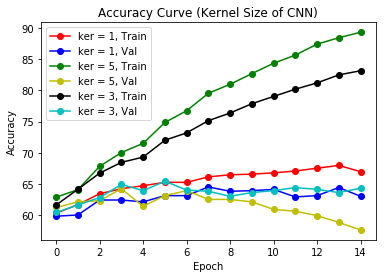

In [148]:
import matplotlib.pyplot as plt

plt.title("Accuracy Curve (Kernel Size of CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")


plt.plot(range(15), CNN_ker_1_train_acc_history, 'o-', color="r",
             label="ker = 1, Train")
plt.plot(range(15), CNN_ker_1_val_acc_history, 'o-', color="b",
             label="ker = 1, Val")
plt.plot(range(15), CNN_ker_5_train_acc_history, 'o-', color="g",
             label="ker = 5, Train")
plt.plot(range(15), CNN_ker_5_val_acc_history, 'o-', color="y",
             label="ker = 5, Val")
plt.plot(range(15), CNN_hidden_100_train_acc_history, 'o-', color="k",
             label="ker = 3, Train")
plt.plot(range(15), CNN_hidden_100_val_acc_history, 'o-', color="c",
             label="ker = 3, Val")
plt.legend(loc="best")

plt.show()



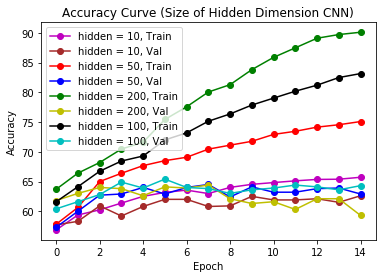

In [161]:
plt.title("Accuracy Curve (Size of Hidden Dimension CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.plot(range(15), CNN_hidden_10_train_acc_history, 'o-', color="m",
             label="hidden = 10, Train")
plt.plot(range(15), CNN_hidden_10_val_acc_history, 'o-', color="brown",
             label="hidden = 10, Val")
plt.plot(range(15), CNN_hidden_50_train_acc_history, 'o-', color="r",
             label="hidden = 50, Train")
plt.plot(range(15), CNN_hidden_50_val_acc_history, 'o-', color="b",
             label="hidden = 50, Val")
plt.plot(range(15), CNN_hidden_200_train_acc_history, 'o-', color="g",
             label="hidden = 200, Train")
plt.plot(range(15), CNN_hidden_200_val_acc_history, 'o-', color="y",
             label="hidden = 200, Val")
plt.plot(range(15), CNN_hidden_100_train_acc_history, 'o-', color="k",
             label="hidden = 100, Train")
plt.plot(range(15), CNN_hidden_100_val_acc_history, 'o-', color="c",
             label="hidden = 100, Val")
plt.legend(loc="best")

plt.show()

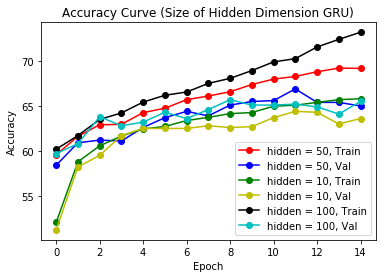

In [46]:
plt.title("Accuracy Curve (Size of Hidden Dimension GRU)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")


plt.plot(range(15), GRU_hidden_50_train_history, 'o-', color="r",
             label="hidden = 50, Train")
plt.plot(range(15), GRU_hidden_50_val_history, 'o-', color="b",
             label="hidden = 50, Val")
plt.plot(range(15), GRU_hidden_10_train_history, 'o-', color="g",
             label="hidden = 10, Train")
plt.plot(range(15), GRU_hidden_10_val_history, 'o-', color="y",
             label="hidden = 10, Val")
plt.plot(range(15), GRU_hidden_100_train_history, 'o-', color="k",
             label="hidden = 100, Train")
plt.plot(range(15), GRU_hidden_100_val_history, 'o-', color="c",
             label="hidden = 100, Val")
plt.legend(loc="best")

plt.show()

In [3]:
GRU_hidden_10_train_history = [52.026, 58.781, 60.562, 61.654, 62.439, 62.721, 63.378, 63.731, 64.147, 64.269, 64.972, 65.088, 65.396, 65.703, 65.806]
GRU_hidden_10_val_history = [51.2, 58.2, 59.5, 61.7, 62.5, 62.5, 62.5, 62.8, 62.6, 62.7, 63.7, 64.4, 64.3, 63.0, 63.6]

## Correct & Incorrect Predictions

In [124]:
val_dataset = SNLIDataset(snli_val, words_ft)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)


In [133]:
def print_correct_predictions(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    i = 0
    for (sen1, len1, sen2, len2, labels) in loader:
        if i > 0: break
        i += 1
        #data_batch, lengths_batch, label_batch = data, lengths, labels
        output = model(sen1, sen2, len1, len2)
        #print(output)
        outputs = F.softmax(output, dim=1)
        #val_loss = criterion(outputs, labels)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        for i in range(32):
            if predicted[i] == labels.view_as(predicted)[i]:
                print('Sentence1: '+ snli_val.loc[i]['sentence1'])
                print('Sentence2: '+ snli_val.loc[i]['sentence2'])
                print('label: ' + snli_val.loc[i]['label'])
                print('Predicted: ' + str(predicted[i]))
                print(' ')
        #print(predicted)
        #print(labels)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [131]:
def print_wrong_predictions(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    i = 0
    for (sen1, len1, sen2, len2, labels) in loader:
        if i > 0: break
        i += 1
        #data_batch, lengths_batch, label_batch = data, lengths, labels
        output = model(sen1, sen2, len1, len2)
        #print(output)
        outputs = F.softmax(output, dim=1)
        #val_loss = criterion(outputs, labels)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        for i in range(32):
            if predicted[i] != labels.view_as(predicted)[i]:
                print('Sentence1: '+ snli_val.loc[i]['sentence1'])
                print('Sentence2: '+ snli_val.loc[i]['sentence2'])
                print('label: ' + snli_val.loc[i]['label'])
                print('Predicted: ' + str(predicted[i]))
                print(' ')
        #print(predicted)
        #print(labels)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [132]:
print_wrong_predictions(val_loader, model)

Sentence1: Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
Sentence2: There are two women standing on the stage
label: contradiction
Predicted: tensor([ 0])
 
Sentence1: Man observes a wavelength given off by an electronic device .
Sentence2: The man is examining what wavelength is given off by the device .
label: entailment
Predicted: tensor([ 1])
 
Sentence1: Two people are in a green forest .
Sentence2: The forest is not dead .
label: entailment
Predicted: tensor([ 2])
 
Sentence1: Three people and a white dog are sitting in the sand on a beach .
Sentence2: Three dogs and a person are sitting in the snow .
label: contradiction
Predicted: tensor([ 0])
 
Sentence1: Man in white shirt and blue jeans looking to the side while walking down a busy sidewalk .
Sentence2: Man has a blue shirt on .

68.75

In [134]:
print_correct_predictions(val_loader, model)

Sentence1: Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
Sentence2: Multiple people are on a subway together , with each of them doing their own thing .
label: entailment
Predicted: tensor([ 0])
 
Sentence1: bicycles stationed while a group of people socialize .
Sentence2: People get together near a stand of bicycles .
label: entailment
Predicted: tensor([ 0])
 
Sentence1: Man in overalls with two horses .
Sentence2: a man in overalls with two horses
label: entailment
Predicted: tensor([ 0])
 
Sentence1: Two men are listening to music through headphones .
Sentence2: Two men listen to music .
label: entailment
Predicted: tensor([ 0])
 
Sentence1: Two women , one walking her dog the other pushing a stroller .
Sentence2: There is a snowstorm .
label: contradiction
Predicted: tensor([ 2])
 
Sentence1: A group of numbered participants walk down the street together .
Sentence2: Participants wait for the beginning of the walkathon .
lab

68.75